The goal of this notebook is to create a random forest that will predict whether or not a passenger has survived the sinking of the titanic. I will also be using a random forest to find the most influencial variables. 

First we need to import our libraries so we can load and clean the data. 

In [1]:
import numpy as np 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

lets look at the types of data we have in our dataframe

In [3]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


As we can see we have 10 data columns and 1 ID column. We can also see that in the Cabin column we have some NaN which we want to deal with first.

In [4]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

This shows the sum of the NaN values across the entire dataframe. These values will make our prediction much more difficult so we need to decide how to move forward. For example we could simply remove these values, however that will reduce the accuracy of our model especially if we find out later that it is a important value. So in this case I think we should replace the missing data with the most common value, or the mode. 

In [5]:
modes = df_train.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [6]:
df_train.fillna(modes, inplace=True)
df_train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Now lets explore more of the data. Below we will look at the numerical columns to further understand what kind of data were looking at. From this we can see that survived, Pclass, SibSp, and Parch are categorical in nature even though they are represented numerically. The Fare Column looks interesting though, so lets look at the distribution.

In [7]:
df_train.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


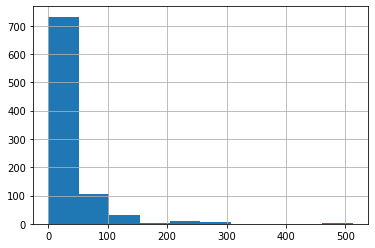

In [8]:
df_train['Fare'].hist();

We can see from this histogram that we have a long tail distribution thats skewed to the right. Some models dont like long tail distributions so lets turn it into something that we can work with by taking the Log of this column.

In [9]:
df_train['LogFare'] = np.log(df_train['Fare'] + 1) # Log of 0 is NaN so we adjust the data to avoid that

Other interesting columns that we want to take deeper look at are the 'Sex', 'Pclass', and "Embarked" Columns. These columns are all integers but they are categorical in nature. Lets encode them in binary to better represent each column. Behind the scenes running pd.Categorical turns the datatype for those columns into Categorical type columns.

In [10]:
df_train['Embarked'] = pd.Categorical(df_train.Embarked)
df_train['Sex'] = pd.Categorical(df_train.Sex)
df_train.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
LogFare         float64
dtype: object

An important thing to remember before you build your model is that you want to modify your test data in exactly the same way as your training data. So I will write a quick function so that we can run it on both sets of data.

To be able to feed this data to a random forest we need to remove the columns that arent categorical or constant and convert all categorical variables into their numerical representations.

In [11]:
def data_modifier(df):
    modes = df.mode().iloc[0]
    df.fillna(modes, inplace=True)
    
    df['LogFare'] = np.log(df['Fare'] + 1)

    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)
    
    df['Sex'] = df.Sex.cat.codes
    df['Embarked'] = df.Embarked.cat.codes
    
    df.drop(['Name','Fare','Ticket','Cabin'],axis=1,inplace=True)
    return df


In [12]:
df_train = data_modifier(df_train)
df_test = data_modifier(df_test)
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,LogFare
0,892,3,1,34.5,0,0,1,2.178064
1,893,3,0,47.0,1,0,2,2.079442
2,894,2,1,62.0,0,0,1,2.369075
3,895,3,1,27.0,0,0,2,2.268252
4,896,3,0,22.0,1,1,2,2.586824


Now lets create an estimation. To do that we are going to fit a randomForestClassifier on the training data and to do that we have to split the data into dependent and independent variables.

In [13]:
df_train_dep = df_train['Survived']
df_train_indep = df_train.drop('Survived',axis=1)

df_train_indep.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,LogFare
0,1,3,1,22.0,1,0,2,2.110213
1,2,1,0,38.0,1,0,0,4.280593
2,3,3,0,26.0,0,0,2,2.188856
3,4,1,0,35.0,1,0,2,3.990834
4,5,3,1,35.0,0,0,2,2.202765


After we made sure to modify our data in exactly the same way we need to create a validation data set so we can measure how well our model performed. To do this we will use train_test_split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
indep_train, indep_val, dep_train, dep_val = train_test_split(df_train_indep, df_train_dep, test_size =0.2,random_state=42)

To measure how well our model performed we will use mean_absolute_error as our metric. Rememeber the lower the error, the more accurate the predictions the model creates.

In [16]:
from sklearn.metrics import mean_absolute_error

In [17]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(indep_train, dep_train)

RandomForestClassifier(min_samples_leaf=5)

In [18]:
mean_absolute_error(dep_val, rf.predict(indep_val))

0.18435754189944134

In [19]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,LogFare
0,892,3,1,34.5,0,0,1,2.178064
1,893,3,0,47.0,1,0,2,2.079442
2,894,2,1,62.0,0,0,1,2.369075
3,895,3,1,27.0,0,0,2,2.268252
4,896,3,0,22.0,1,1,2,2.586824


We can see here that the error is 0.189 which translates to an accuracy of 0.811 or 81% which is pretty good!

Now that we have this model we might want to better understand what variables have the most influence in the model. Two of the more common ways to visualize importance for a RF are Feature_importances and Waterfall Plots. Lets start with Feature_importances first.

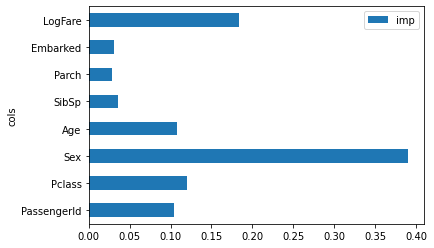

In [21]:
pd.DataFrame(dict(cols=indep_train.columns, imp=rf.feature_importances_)).plot('cols','imp','barh');

Here we can see that the 'Sex' column was the most important column by far with the runner up being the LogFare column. In a case where the number of columns you have is massive, finding the feature importances is crucial for reducing the time it takes to explore the data.

Now we can create a submission to kaggle!

In [ ]:
def subm(preds, suff):
    df_test["Survived"] = preds
    sub_df = df_test[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)
    
subm(rf.predict(df_test), 'rf')